## Generate Sentinel geomedians for time groupings
This notebook shows you how to download S2 data for an area and time and then generate geomedian for specific time groupings within the cube (e.g. per month, per season)

In [1]:
%matplotlib inline

import warnings

import datacube
import numpy as np
from odc.algo import int_geomedian, to_f32, xr_geomedian

warnings.filterwarnings("ignore")

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

In [2]:
# Set up the Dask cluster
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33715 Dashboard: /user/lmitch/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


In [3]:
# Connect to the datacube
dc = datacube.Datacube(app="Generating_geomedian_group_composites")

In [4]:
# Create a reusable query (can change resolution and/or bands here if needed)
query = {
    "lat": (-40.188, -40.214),
    "lon": (148.228, 148.268),
    "time": ("2019-01", "2019-12"),  # Months or day can be specified here
    "measurements": [
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "nbart_swir_2",
    ],  # Can add nbart_swir_2 for true flase colour but change res to 20 (or resample 10m)
    "output_crs": "EPSG:3577",
    "resolution": (-20, 20),
    "group_by": "solar_day",
}

Compared to the typical use of load_ard which by default returns data with floating point numbers containing NaN (i.e. float32), in this example we will set the dtype to 'native'. This will keep our data in its original integer data type (i.e. Int16), with nodata values marked with -999. Doing this will halve the amount of memory our data takes up, which can be extremely valuable when conducting large-scale analyses.

In [5]:
# Load available data (try min_gooddata to limit clouds)
ds = load_ard(
    dc=dc,
    products=["s2a_ard_granule", "s2b_ard_granule"],
    dask_chunks={"x": 2000, "y": 2000},
    dtype="native",
    min_gooddata=0.1,
    **query
)

# Print output data
ds

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 40 out of 70 time steps with at least 10.0% good quality pixels
Applying pixel quality/cloud mask
Returning 40 time steps as a dask array


<xarray.Dataset>
Dimensions:       (time: 40, y: 164, x: 191)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-10T00:07:57.217000 ... 2019-1...
  * y             (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x             (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
    nbart_red     (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Plot timesteps in true colour¶
To visualise the data, use the pre-loaded rgb utility function to plot a true colour image for a series of timesteps. Black areas indicate where clouds or other invalid pixels in the image have been set to -999 to indicate no data.

The code below will plot three timesteps of the time series we just loaded.

Note: This step can be quite slow because the dask arrays being plotted must be computed first.

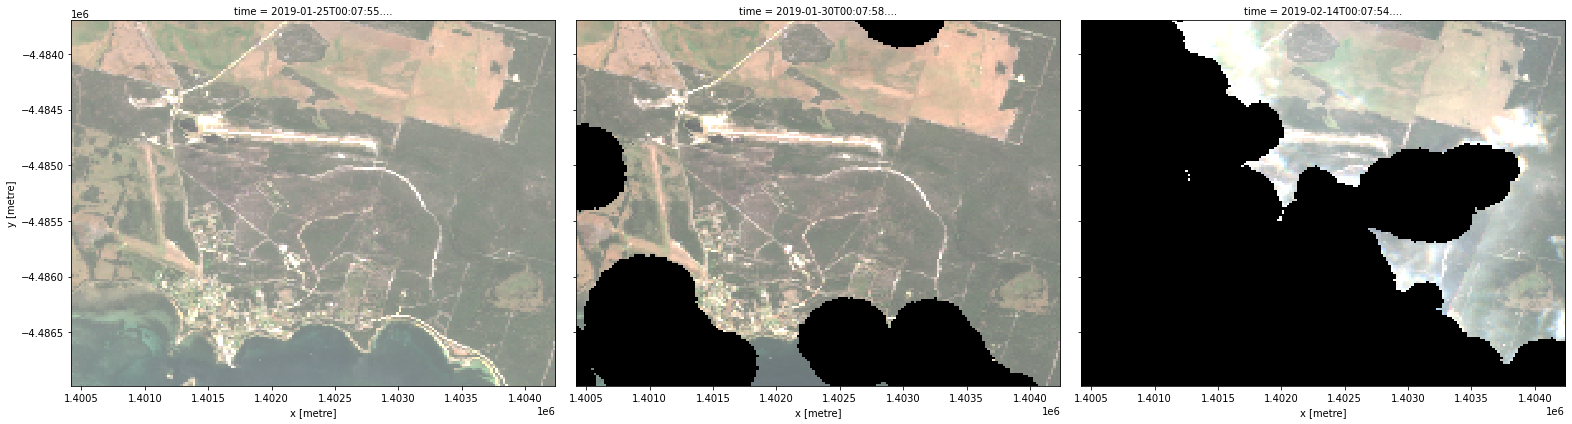

In [6]:
# Set the timesteps to visualise
timesteps = [2, 3, 5]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)

## Generate Geomedian
Running the int_geomedian function will generate a geomedian composite by combining all the observations in our xarray.Dataset into a single, complete (or near complete) image representing the geometric median of the time period.

Note: Because our data was lazily loaded with dask, the geomedian algorithm itself will not be triggered until we call the .compute() method in the next step.

In [7]:
geomedian = int_geomedian(ds)

The .compute() method will trigger the computation of the geomedian algorithm above. This will take about a few minutes to run; view the dask dashboard to check the progress.

In [8]:
%%time
geomedian = geomedian.compute()

CPU times: user 1.55 s, sys: 179 ms, total: 1.73 s
Wall time: 57.4 s


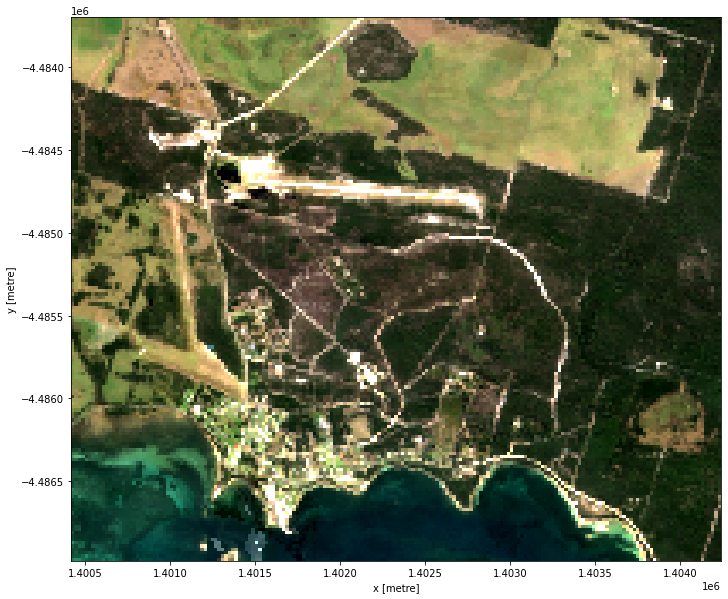

In [9]:
# Plot the result
rgb(geomedian, size=10)

## Running geomedian on grouped or resampled timeseries
We can run the geomedian function on time groupings within our ds.
First we will split the timeseries into the desired groups. Resampling can be used to create a new set of times at regular intervals:

* grouped = da_scaled.resample(time=1M)
    * 'nD' - number of days (e.g. '7D' for seven days)
    * 'nM' - number of months (e.g. '6M' for six months)
    * 'nY' - number of years (e.g. '2Y' for two years)

Grouping works by looking at part of the date, but ignoring other parts. For instance, 'time.month' would group together all January data together, no matter what year it is from.

* grouped = da_scaled.groupby('time.month')
    * 'time.day' - groups by the day of the month (1-31)
    * 'time.dayofyear' - groups by the day of the year (1-365)
    * 'time.week' - groups by week (1-52)
    * 'time.month' - groups by the month (1-12)
    * 'time.season' - groups into 3-month seasons:
        * 'DJF' December, January, February
        * 'MAM' March, April, May
        * 'JJA' June, July, August
        * 'SON' September, October, November
        * 'time.year' - groups by the year

In [11]:
# If multiple years of 'nominal summer' images have been loaded, group by year ending June 30
#grouped = ds.resample(time='A-JUN') # Annual ending in June (see pandas anchored offsets aliases)

# Resample into three four-monthly groups ('4M'), with the group starting at the start of the month (represented by the 'S' at the end).
#grouped = ds.resample(time='4MS')

grouped = ds.groupby('time.month') # grouped into months - will now have a 'month' dimension rather than 'time'
grouped

DatasetResample, grouped over '__resample_dim__'
3 groups with labels 2019-01-01, ..., 2019-09-01.

Now we will apply the int_geomedian function to each resampled group using the map method.

Instead of calling int_geomedian(ds) on the entire array, we pass the int_geomedian function to map to apply it separately to each resampled group.

In [40]:
#geomedian_grouped = int_geomedian.map(grouped)
#geomedian = int_geomedian(ds)
geomedian_grouped = grouped.map(int_geomedian)

In [41]:
# And compute the geomedian
%%time
geomedian_grouped = geomedian_grouped.compute()

UsageError: Line magic function `%%time` not found.


In [42]:
geomedian_grouped

<xarray.Dataset>
Dimensions:       (time: 2, y: 164, x: 191)
Coordinates:
  * time          (time) datetime64[ns] 2019-06-30 2020-06-30
  * y             (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x             (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
Data variables:
    nbart_blue    (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
    nbart_red     (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 164, 191), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

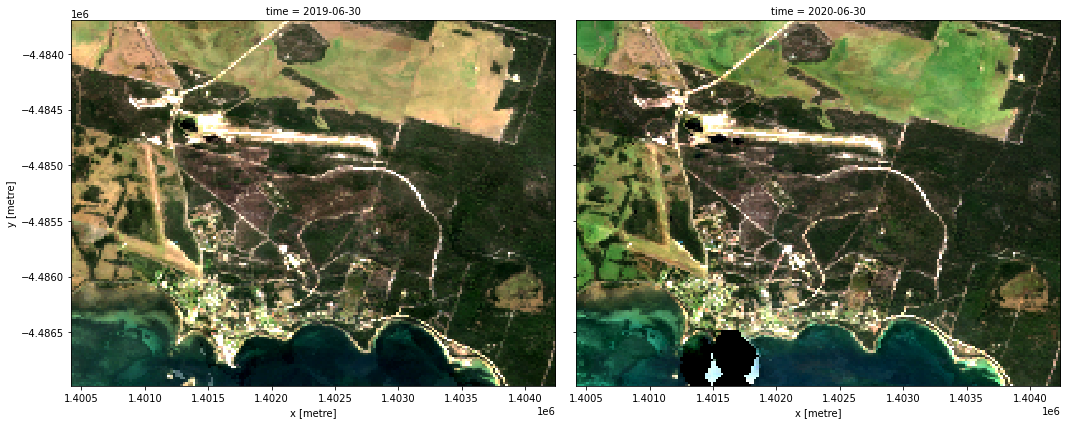

In [43]:
rgb(geomedian_grouped, col='time', col_wrap=4) # change 'col' if ds is grouped rather than resampled